In [1]:
# import library

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import datetime
import tensorflow as tf

from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, GRU
from keras.layers import *
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam, SGD

In [2]:
# singkronisasi ke g-drive

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# membaca dataset

dataset = pd.read_csv('/content/drive/MyDrive/MLT2/covid_impact_on_airport_traffic.csv')

## 1. Explorasi Data

In [4]:
# melihat gambaran data

data = dataset.copy()
data.head()

,AggregationMethod,Date,Version,AirportName,PercentOfBaseline,Centroid,City,State,ISO_3166_2,Country,Geography
0,Daily,2020-04-03,1.0,Kingsford Smith,64,POINT(151.180087713813 -33.9459774986125),Sydney,New South Wales,AU,Australia,"POLYGON((151.164354085922 -33.9301772341877, 1..."
1,Daily,2020-04-13,1.0,Kingsford Smith,29,POINT(151.180087713813 -33.9459774986125),Sydney,New South Wales,AU,Australia,"POLYGON((151.164354085922 -33.9301772341877, 1..."
2,Daily,2020-07-10,1.0,Kingsford Smith,54,POINT(151.180087713813 -33.9459774986125),Sydney,New South Wales,AU,Australia,"POLYGON((151.164354085922 -33.9301772341877, 1..."
3,Daily,2020-09-02,1.0,Kingsford Smith,18,POINT(151.180087713813 -33.9459774986125),Sydney,New South Wales,AU,Australia,"POLYGON((151.164354085922 -33.9301772341877, 1..."
4,Daily,2020-10-31,1.0,Kingsford Smith,22,POINT(151.180087713813 -33.9459774986125),Sydney,New South Wales,AU,Australia,"POLYGON((151.164354085922 -33.9301772341877, 1..."


In [5]:
# melihat info data

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7247 entries, 0 to 7246
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   AggregationMethod  7247 non-null   object 
 1   Date               7247 non-null   object 
 2   Version            7247 non-null   float64
 3   AirportName        7247 non-null   object 
 4   PercentOfBaseline  7247 non-null   int64  
 5   Centroid           7247 non-null   object 
 6   City               7247 non-null   object 
 7   State              7247 non-null   object 
 8   ISO_3166_2         7247 non-null   object 
 9   Country            7247 non-null   object 
 10  Geography          7247 non-null   object 
dtypes: float64(1), int64(1), object(9)
memory usage: 622.9+ KB


In [6]:
# melihat pengelompokan 1

groupby_df = data.groupby(['Country', 'AirportName']).agg({
   'Date'  : 'nunique', 
   'City'  : 'unique',
   'State' : 'unique',
   'PercentOfBaseline' : 'nunique'
})

groupby_df

Date  \
Country                        AirportName                                       
Australia                      Kingsford Smith                             257   
Canada                         Calgary International                       261   
                               Edmonton International                      236   
                               Halifax International                       252   
                               Hamilton International                      260   
                               Montreal Mirabel                            257   
                               Montreal Trudeau                            262   
                               Toronto Pearson                             261   
                               Vancouver International                     261   
                               Winnipeg International                      261   
Chile                          Santiago International Airport              238   
United States of America (the) Boston Logan International                  261   
                               Charlotte Douglas International             261   
                               Chicago OHare International                 261   
                               Dallas/Fort Worth International             262   
                               Daniel K. Inouye International              261   
                               Denver International                        261   
                               Detroit Metropolitan Wayne County           261   
                               Hartsfield-Jackson Atlanta International    262   
                               John F. Kennedy International               262   
                               LaGuardia                                   261   
                               Los Angeles International                   262   
                               McCarran International                      261   
                               Miami International                         261   
                               Newark Liberty International                261   
                               San Francisco International                 261   
                               Seattle-Tacoma International                261   
                               Washington Dulles International             261   

                                                                                           City  \
Country                        AirportName                                                        
Australia                      Kingsford Smith                                         [Sydney]   
Canada                         Calgary International                                  [Calgary]   
                               Edmonton International                            [Leduc County]   
                               Halifax International                                  [Halifax]   
                               Hamilton International                                [Hamilton]   
                               Montreal Mirabel                                       [Mirabel]   
                               Montreal Trudeau                                        [Dorval]   
                               Toronto Pearson                                    [Mississauga]   
                               Vancouver International                               [Richmond]   
                               Winnipeg International                                [Winnipeg]   
Chile                          Santiago International Airport                        [Santiago]   
United States of America (the) Boston Logan International                              [Boston]   
                               Charlotte Douglas International                      [Charlotte]   
                               Chicago OHare International                            [Chicago]   
                             

In [7]:
# melihat pengelompokan 2

kelompok = data.groupby("Country")[['State','City','AirportName']].nunique()

kelompok

,State,City,AirportName
Country,,,
Australia,1,1,1
Canada,6,9,9
Chile,1,1,1
United States of America (the),15,16,17


Text(0, 0.5, 'Percent of baseline')

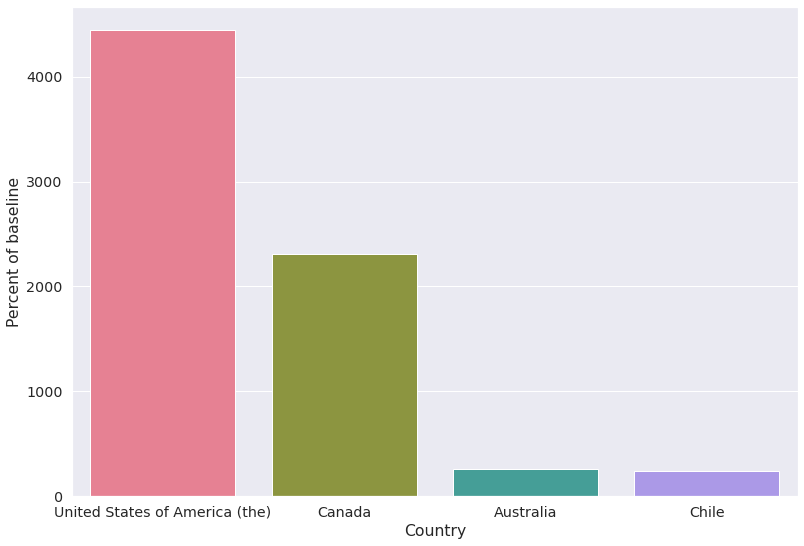

In [8]:
# visualisasi grafik

df1 = data.groupby("Country")['PercentOfBaseline'].count().sort_values(ascending = False).reset_index()
sns.set(font_scale = 1.3)
plt.figure(figsize = [13,9])
sns.barplot(data = df1, x=  'Country', y = 'PercentOfBaseline',palette = 'husl')
plt.ylabel('Percent of baseline')

In [9]:
# melihat tabel

df1

,Country,PercentOfBaseline
0,United States of America (the),4441
1,Canada,2311
2,Australia,257
3,Chile,238


## 2. Data Pre-processing

In [10]:
# mengubah tipe data

data['Date'] = pd.to_datetime(data['Date'])

In [11]:
# cek nilai yang hilang (kosong)

round(100*(data.isnull().sum()/len(data.index)), 2).sort_values(ascending=False)

AggregationMethod    0.0
Date                 0.0
Version              0.0
AirportName          0.0
PercentOfBaseline    0.0
Centroid             0.0
City                 0.0
State                0.0
ISO_3166_2           0.0
Country              0.0
Geography            0.0
dtype: float64

In [12]:
# cek data duplikat dan menghapus semua duplikat jika ada

data.drop_duplicates(subset=None, inplace=True)


# melihat hasil

data.shape

(7247, 11)

In [13]:
# menghilangkan data yang tidak digunakan

df = data.drop(columns=['AggregationMethod', 'Version', 'Centroid', 'ISO_3166_2', 'Geography'])

In [14]:
# melihat df

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7247 entries, 0 to 7246
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Date               7247 non-null   datetime64[ns]
 1   AirportName        7247 non-null   object        
 2   PercentOfBaseline  7247 non-null   int64         
 3   City               7247 non-null   object        
 4   State              7247 non-null   object        
 5   Country            7247 non-null   object        
dtypes: datetime64[ns](1), int64(1), object(4)
memory usage: 396.3+ KB


## 3. Analisis Negara

In [15]:
# 4 negara : pilih data

df_usa = df[df['Country']=='United States of America (the)']
df_usa = pd.DataFrame(df_usa.groupby('Date',as_index=False)['PercentOfBaseline'].mean())
print('Data USA :\n', df_usa.head())

df_canada = df[df['Country']=='Canada']
df_canada = pd.DataFrame(df_canada.groupby('Date',as_index=False)['PercentOfBaseline'].mean())
print('Data Canda :\n', df_canada.head())

df_chile = df[df['Country']=='Chile']
df_chile = df_chile.drop(columns=['AirportName','City','State','Country']).sort_values(by="Date")
print('Data Chile :\n', df_chile.head())

df_australia = df[df['Country']=='Australia']
df_australia = df_australia.drop(columns=['AirportName','City','State','Country']).sort_values(by="Date")
print('Data Australia :\n', df_australia.head())

Data USA :
         Date  PercentOfBaseline
0 2020-03-16          88.058824
1 2020-03-17          87.823529
2 2020-03-18          81.705882
3 2020-03-19          73.764706
4 2020-03-20          73.058824
Data Canda :
         Date  PercentOfBaseline
0 2020-03-16          92.333333
1 2020-03-17          87.888889
2 2020-03-18          88.000000
3 2020-03-19          84.777778
4 2020-03-20          86.666667
Data Chile :
           Date  PercentOfBaseline
302 2020-03-16                 96
257 2020-03-17                 72
393 2020-03-18                 56
473 2020-03-19                 52
414 2020-03-20                 53
Data Australia :
           Date  PercentOfBaseline
171 2020-03-16                 92
31  2020-03-17                 90
129 2020-03-18                 97
84  2020-03-19                 89
65  2020-03-20                 85


In [16]:
# melihat rentang tanggal dataset masing-masing negara

print('Tanggal USA Awal :\n', df_usa['Date'].head())
print('Tanggal USA Akhir :\n', df_usa['Date'].tail())

print('Tanggal Canada Awal :\n', df_canada['Date'].head())
print('Tanggal Canada Akhir :\n', df_canada['Date'].tail())

print('Tanggal Chile Awal :\n', df_chile['Date'].head())
print('Tanggal Chile Akhir :\n', df_chile['Date'].tail())

print('Tanggal Australia Awal :\n', df_australia['Date'].head())
print('Tanggal Australia Akhir :\n', df_australia['Date'].tail())


Tanggal USA Awal :
 0   2020-03-16
1   2020-03-17
2   2020-03-18
3   2020-03-19
4   2020-03-20
Name: Date, dtype: datetime64[ns]
Tanggal USA Akhir :
 257   2020-11-28
258   2020-11-29
259   2020-11-30
260   2020-12-01
261   2020-12-02
Name: Date, dtype: datetime64[ns]
Tanggal Canada Awal :
 0   2020-03-16
1   2020-03-17
2   2020-03-18
3   2020-03-19
4   2020-03-20
Name: Date, dtype: datetime64[ns]
Tanggal Canada Akhir :
 257   2020-11-28
258   2020-11-29
259   2020-11-30
260   2020-12-01
261   2020-12-02
Name: Date, dtype: datetime64[ns]
Tanggal Chile Awal :
 302   2020-03-16
257   2020-03-17
393   2020-03-18
473   2020-03-19
414   2020-03-20
Name: Date, dtype: datetime64[ns]
Tanggal Chile Akhir :
 369   2020-11-27
292   2020-11-28
337   2020-11-30
469   2020-12-01
338   2020-12-02
Name: Date, dtype: datetime64[ns]
Tanggal Australia Awal :
 171   2020-03-16
31    2020-03-17
129   2020-03-18
84    2020-03-19
65    2020-03-20
Name: Date, dtype: datetime64[ns]
Tanggal Australia Akhir :
 1

In [17]:
# info 4 negara

df_usa.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 262 entries, 0 to 261
Data columns (total 2 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Date               262 non-null    datetime64[ns]
 1   PercentOfBaseline  262 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 4.2 KB


In [18]:
df_canada.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 262 entries, 0 to 261
Data columns (total 2 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Date               262 non-null    datetime64[ns]
 1   PercentOfBaseline  262 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 4.2 KB


In [19]:
df_chile.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 238 entries, 302 to 338
Data columns (total 2 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Date               238 non-null    datetime64[ns]
 1   PercentOfBaseline  238 non-null    int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 5.6 KB


In [20]:
df_australia.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 257 entries, 171 to 198
Data columns (total 2 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Date               257 non-null    datetime64[ns]
 1   PercentOfBaseline  257 non-null    int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 6.0 KB


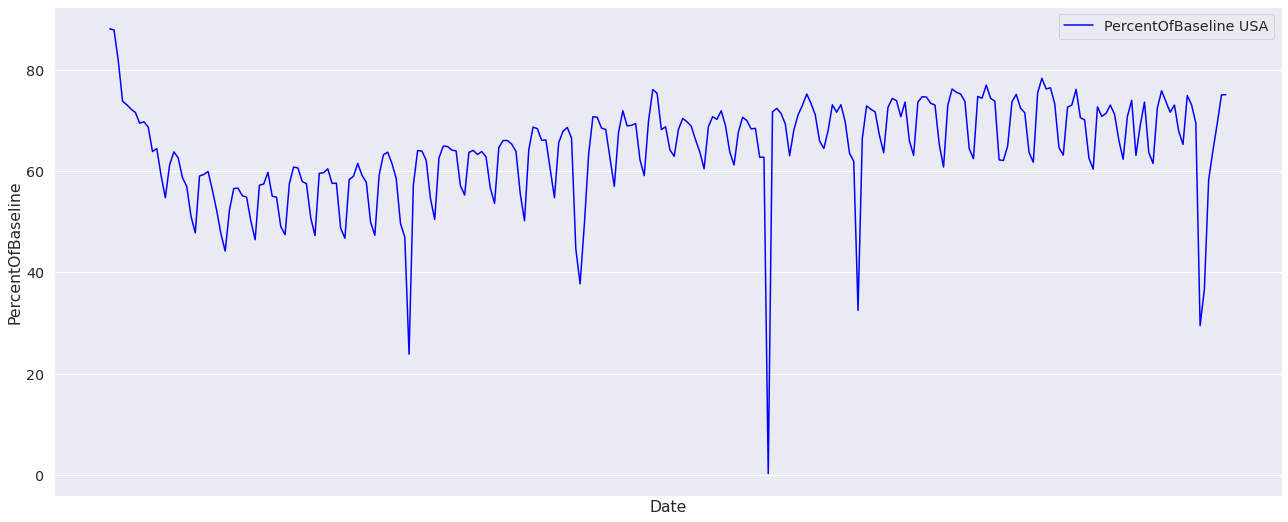

In [21]:
# membuat grafik usa

plt.figure(figsize=(22,9))
plt.plot(df_usa['Date'].values, df_usa['PercentOfBaseline'].values, label = 'PercentOfBaseline USA', color = 'blue')
plt.xticks(np.arange(100,df_usa.shape[0],200))
plt.xlabel('Date')
plt.ylabel('PercentOfBaseline')
plt.legend()
plt.show()

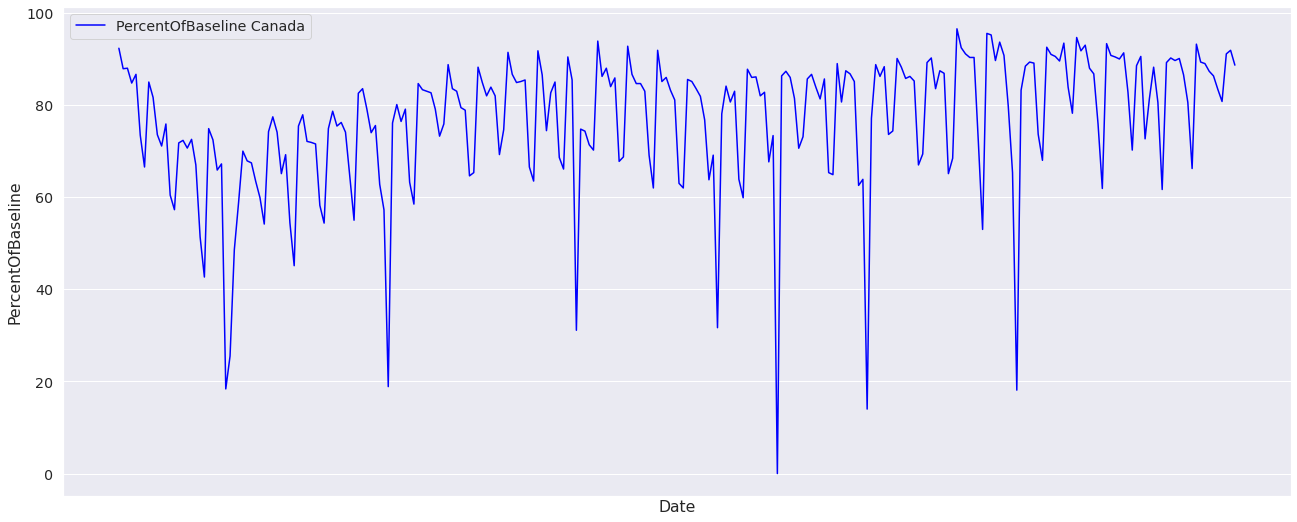

In [22]:
# membuat grafik canada

plt.figure(figsize=(22,9))
plt.plot(df_canada['Date'].values, df_canada['PercentOfBaseline'].values, label = 'PercentOfBaseline Canada', color = 'blue')
plt.xticks(np.arange(100,df_usa.shape[0],200))
plt.xlabel('Date')
plt.ylabel('PercentOfBaseline')
plt.legend()
plt.show()

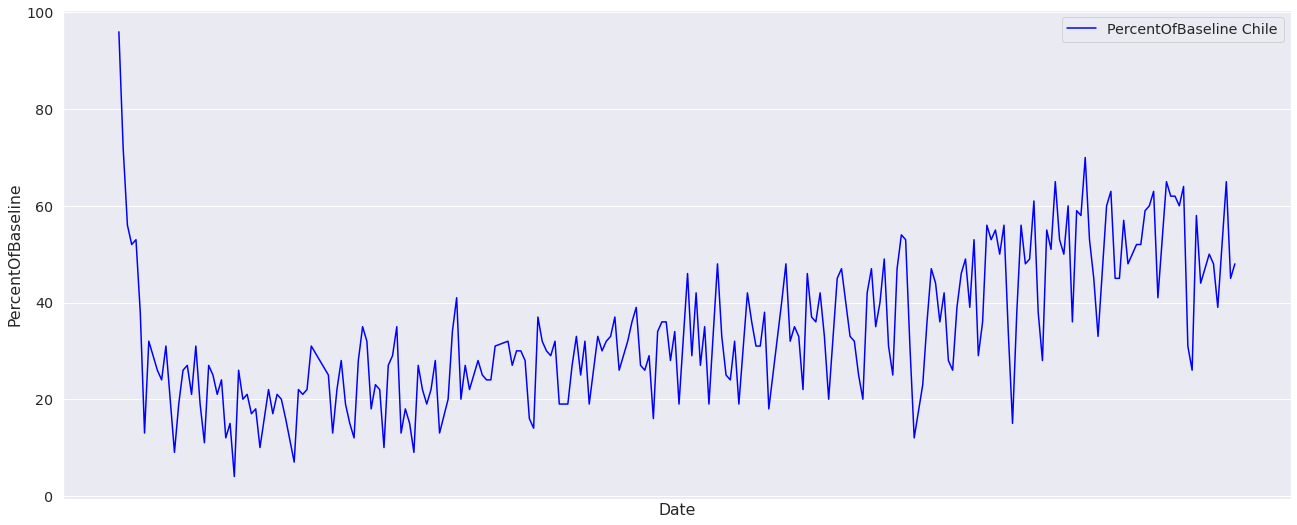

In [23]:
# membuat grafik chile

plt.figure(figsize=(22,9))
plt.plot(df_chile['Date'].values, df_chile['PercentOfBaseline'].values, label = 'PercentOfBaseline Chile', color = 'blue')
plt.xticks(np.arange(100,df_usa.shape[0],200))
plt.xlabel('Date')
plt.ylabel('PercentOfBaseline')
plt.legend()
plt.show()

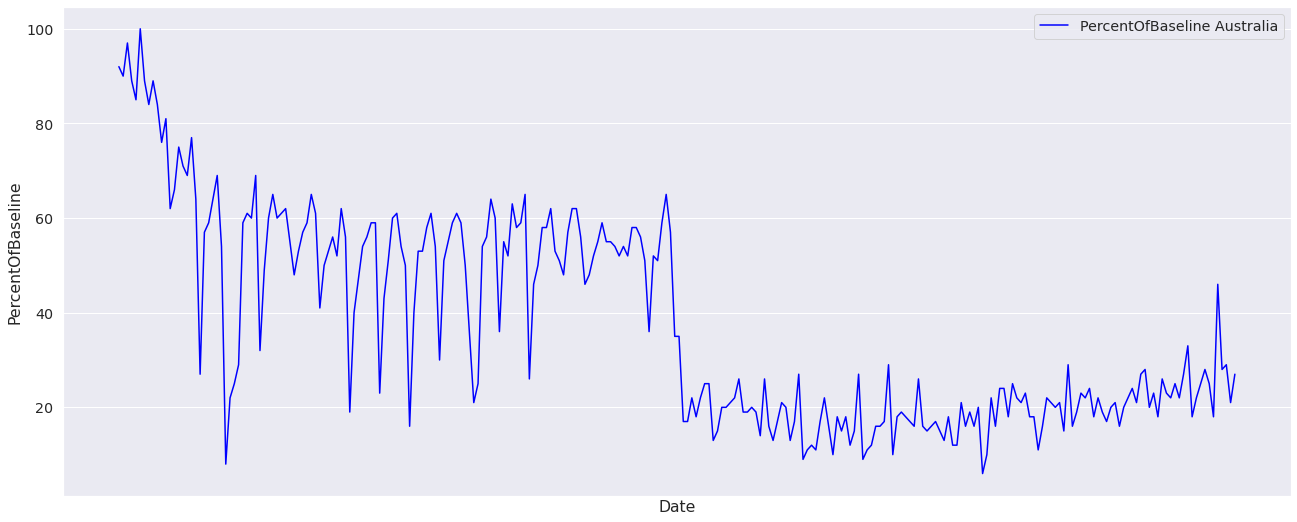

In [24]:
# membuat grafik australia

plt.figure(figsize=(22,9))
plt.plot(df_australia['Date'].values, df_australia['PercentOfBaseline'].values, label = 'PercentOfBaseline Australia', color = 'blue')
plt.xticks(np.arange(100,df_usa.shape[0],200))
plt.xlabel('Date')
plt.ylabel('PercentOfBaseline')
plt.legend()
plt.show()

## 4. Machine Learning

#### 4.1 Negara USA

In [25]:
# dataset USA

df_usa.head()

,Date,PercentOfBaseline
0,2020-03-16,88.058824
1,2020-03-17,87.823529
2,2020-03-18,81.705882
3,2020-03-19,73.764706
4,2020-03-20,73.058824


In [26]:
# membuat data train

df_train_usa = df_usa[:235]

In [27]:
# melihat info

df_train_usa.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 235 entries, 0 to 234
Data columns (total 2 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Date               235 non-null    datetime64[ns]
 1   PercentOfBaseline  235 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 3.8 KB


In [28]:
# memilih kolom yang digunakan

training_set_usa = df_train_usa['PercentOfBaseline']

In [29]:
# membuat dataframe train

training_set_usa = pd.DataFrame(training_set_usa)

In [30]:
# standarisasi nilai

scale_usa = MinMaxScaler(feature_range = (0, 1))

training_set_scaled_usa = scale_usa.fit_transform(training_set_usa)

In [31]:
# membuat struktur data dengan 30 timesteps dan 1 output

X_train = []
y_train = []

for i in range(30, 235):
    X_train.append(training_set_scaled_usa[i-30:i, 0])
    y_train.append(training_set_scaled_usa[i, 0])

X_train, y_train = np.array(X_train), np.array(y_train)

In [32]:
# Reshaping

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

In [33]:
# Inisialisasi RNN

model_usa = Sequential()

In [34]:
# menambahkan layer LSTM pertama dan mengatur Dropout
model_usa.add(LSTM(
    units = 60,
    activation = 'tanh',
    return_sequences = True,
    input_shape = (X_train.shape[1], 1)
))
model_usa.add(Dropout(0.2))

# menambahkan layer LSTM kedua dan mengatur Dropout
model_usa.add(LSTM(
    units = 80,
    activation = 'relu',
    return_sequences = True
))
model_usa.add(Dropout(0.2))

# menambahkan layer LSTM ketiga dan mengatur Dropout
model_usa.add(LSTM(
    units = 100,
    activation = 'tanh',
    return_sequences = True
))
model_usa.add(Dropout(0.2))

# menambahkan layer LSTM keempat dan mengatur Dropout
model_usa.add(LSTM(
    units = 120
))
model_usa.add(Dropout(0.2))

# menambahkan layer output
model_usa.add(Dense(
    units = 1
))

# rangkuman
model_usa.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 30, 60)            14880     
                                                                 
 dropout (Dropout)           (None, 30, 60)            0         
                                                                 
 lstm_1 (LSTM)               (None, 30, 80)            45120     
                                                                 
 dropout_1 (Dropout)         (None, 30, 80)            0         
                                                                 
 lstm_2 (LSTM)               (None, 30, 100)           72400     
                                                                 
 dropout_2 (Dropout)         (None, 30, 100)           0         
                                                                 
 lstm_3 (LSTM)               (None, 120)               1

In [35]:
# Compile RNN

model_usa.compile(optimizer = 'adam', loss = 'mean_squared_error')

In [36]:
# menerapkan RNN ke dalam train set

epoch = 100 
batch_size = 32

model_usa.fit(X_train, y_train, epochs = epoch, batch_size = batch_size)

Epoch 1/100
7/7 [==============================] - 11s 71ms/step - loss: 0.2659
Epoch 2/100
7/7 [==============================] - 0s 72ms/step - loss: 0.0548
Epoch 3/100
7/7 [==============================] - 0s 71ms/step - loss: 0.0249
Epoch 4/100
7/7 [==============================] - 0s 71ms/step - loss: 0.0156
Epoch 5/100
7/7 [==============================] - 0s 68ms/step - loss: 0.0167
Epoch 6/100
7/7 [==============================] - 0s 63ms/step - loss: 0.0143
Epoch 7/100
7/7 [==============================] - 0s 60ms/step - loss: 0.0132
Epoch 8/100
7/7 [==============================] - 0s 66ms/step - loss: 0.0121
Epoch 9/100
7/7 [==============================] - 0s 66ms/step - loss: 0.0127
Epoch 10/100
7/7 [==============================] - 0s 68ms/step - loss: 0.0118
Epoch 11/100
7/7 [==============================] - 0s 67ms/step - loss: 0.0125
Epoch 12/100
7/7 [==============================] - 0s 69ms/step - loss: 0.0132
Epoch 13/100
7/7 [==============================

In [37]:
# membuat data test

df_test_usa = df_usa[235:]

In [38]:
# melihat info

df_test_usa.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27 entries, 235 to 261
Data columns (total 2 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Date               27 non-null     datetime64[ns]
 1   PercentOfBaseline  27 non-null     float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 564.0 bytes


In [39]:
# memilih kolom yang digunakan

testing_set_usa = df_test_usa['PercentOfBaseline']

In [40]:
# membuat dataframe test

testing_set_usa = pd.DataFrame(testing_set_usa)

In [41]:
# melihat info

testing_set_usa.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27 entries, 235 to 261
Data columns (total 1 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   PercentOfBaseline  27 non-null     float64
dtypes: float64(1)
memory usage: 348.0 bytes


In [42]:
# melihat data asli

real_percentofbaseline_usa = testing_set_usa.values

real_percentofbaseline_usa

array([[71.17647059],
       [66.05882353],
       [62.29411765],
       [70.76470588],
       [73.94117647],
       [63.05882353],
       [69.        ],
       [73.58823529],
       [63.64705882],
       [61.47058824],
       [72.41176471],
       [75.82352941],
       [73.70588235],
       [71.58823529],
       [73.        ],
       [67.82352941],
       [65.23529412],
       [74.88235294],
       [73.05882353],
       [69.47058824],
       [29.47058824],
       [36.58823529],
       [58.23529412],
       [64.        ],
       [69.29411765],
       [75.        ],
       [75.05882353]])

In [43]:
# mendapatkan data prediksi

dataset_total_usa = pd.concat((df_train_usa['PercentOfBaseline'], df_test_usa['PercentOfBaseline']), axis = 0)

inputs_usa = dataset_total_usa[len(dataset_total_usa) - len(df_test_usa) - 30:].values
inputs_usa = inputs_usa.reshape(-1, 1)
inputs_usa = scale_usa.transform(inputs_usa)

X_test = []

for i in range(30, 57):
    X_test.append(inputs_usa[i-30:i, 0])
    
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

predicted_percentofbaseline_usa = model_usa.predict(X_test)
predicted_percentofbaseline_usa = scale_usa.inverse_transform(predicted_percentofbaseline_usa)

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"


In [56]:
# melihat X_test

X_test.shape

(27, 30, 1)

In [57]:
# membuat dataframe prediksi

predicted_percentofbaseline_usa = pd.DataFrame(predicted_percentofbaseline_usa)

In [58]:
# melihat info

predicted_percentofbaseline_usa.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27 entries, 0 to 26
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       27 non-null     float32
dtypes: float32(1)
memory usage: 236.0 bytes


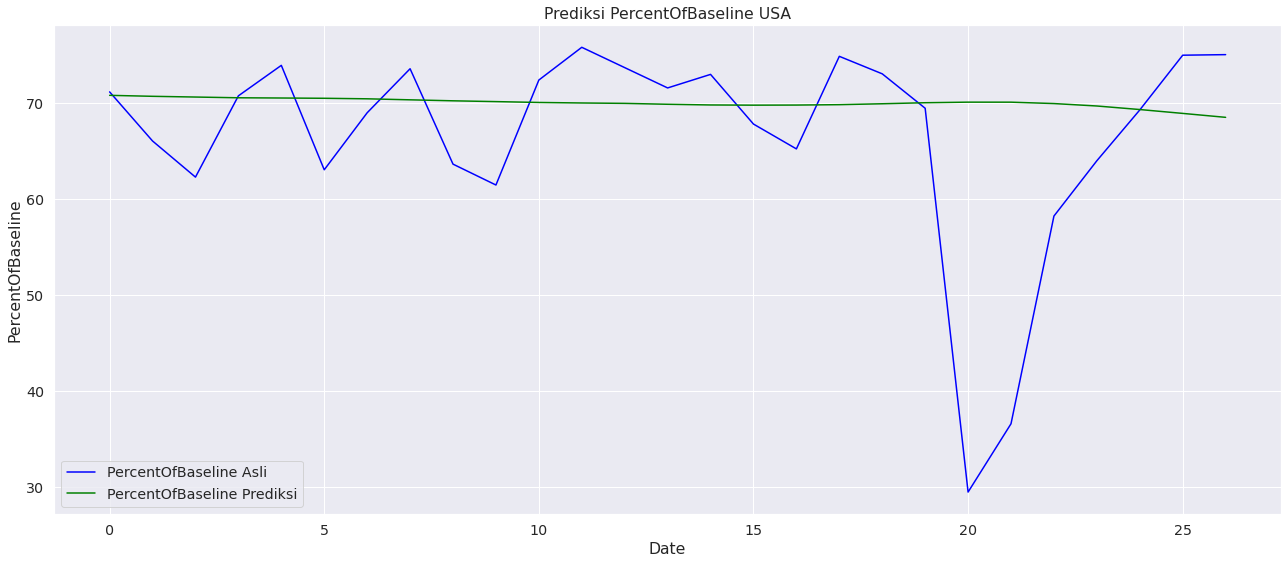

In [59]:
# Visualisasi hasil

plt.figure(figsize=(22,9))
plt.plot(real_percentofbaseline_usa, color = 'blue', label = 'PercentOfBaseline Asli')
plt.plot(predicted_percentofbaseline_usa, color = 'green', label = 'PercentOfBaseline Prediksi')
plt.title('Prediksi PercentOfBaseline USA')
plt.xlabel('Date')
plt.ylabel('PercentOfBaseline')
plt.legend(loc="lower left")
plt.show()

#### 4.2 Negara Canada

In [60]:
# dataset Canada

df_canada.head()

,Date,PercentOfBaseline
0,2020-03-16,92.333333
1,2020-03-17,87.888889
2,2020-03-18,88.000000
3,2020-03-19,84.777778
4,2020-03-20,86.666667


In [61]:
# membuat data train 

df_train_canada = df_canada[:235]

In [62]:
# melihat info

df_train_canada.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 235 entries, 0 to 234
Data columns (total 2 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Date               235 non-null    datetime64[ns]
 1   PercentOfBaseline  235 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 3.8 KB


In [63]:
# memilih kolom yang digunakan

training_set_canada = df_train_canada['PercentOfBaseline']

In [64]:
# membuat dataframe train

training_set_canada = pd.DataFrame(training_set_canada)

In [65]:
# standarisasi nilai

scale_canada = MinMaxScaler(feature_range = (0, 1))

training_set_scaled_canada = scale_canada.fit_transform(training_set_canada)

In [66]:
# membuat struktur data dengan 30 timesteps dan 1 output

X_train = []
y_train = []

for i in range(30, 235):
    X_train.append(training_set_scaled_canada[i-30:i, 0])
    y_train.append(training_set_scaled_canada[i, 0])
    
X_train, y_train = np.array(X_train), np.array(y_train)

In [67]:
# Reshaping

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

In [68]:
# Inisialisasi RNN

model_canada = Sequential()

In [69]:
# menambahkan layer LSTM pertama dan mengatur Dropout
model_canada.add(LSTM(
    units = 60,
    activation = 'tanh',
    return_sequences = True,
    input_shape = (X_train.shape[1], 1)
))
model_canada.add(Dropout(0.2))

# menambahkan layer LSTM kedua dan mengatur Dropout
model_canada.add(LSTM(
    units = 80,
    activation = 'relu',
    return_sequences = True
))
model_canada.add(Dropout(0.2))

# menambahkan layer LSTM ketiga dan mengatur Dropout
model_canada.add(LSTM(
    units = 100,
    activation = 'tanh',
    return_sequences = True
))
model_canada.add(Dropout(0.2))

# menambahkan layer LSTM keempat dan mengatur Dropout
model_canada.add(LSTM(
    units = 120
))
model_canada.add(Dropout(0.2))

# menambahkan layer output
model_canada.add(Dense(
    units = 1
))

# rangkuman
model_canada.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 30, 60)            14880     
                                                                 
 dropout_4 (Dropout)         (None, 30, 60)            0         
                                                                 
 lstm_5 (LSTM)               (None, 30, 80)            45120     
                                                                 
 dropout_5 (Dropout)         (None, 30, 80)            0         
                                                                 
 lstm_6 (LSTM)               (None, 30, 100)           72400     
                                                                 
 dropout_6 (Dropout)         (None, 30, 100)           0         
                                                                 
 lstm_7 (LSTM)               (None, 120)              

In [70]:
# Compile RNN

model_canada.compile(optimizer = 'adam', loss = 'mean_squared_error')

In [71]:
# menerapkan RNN ke dalam train set

epoch = 100 
batch_size = 32

model_canada.fit(X_train, y_train, epochs = epoch, batch_size = batch_size)

Epoch 1/100
7/7 [==============================] - 6s 105ms/step - loss: 0.3161
Epoch 2/100
7/7 [==============================] - 1s 173ms/step - loss: 0.0771
Epoch 3/100
7/7 [==============================] - 1s 153ms/step - loss: 0.0458
Epoch 4/100
7/7 [==============================] - 1s 169ms/step - loss: 0.0337
Epoch 5/100
7/7 [==============================] - 0s 65ms/step - loss: 0.0286
Epoch 6/100
7/7 [==============================] - 0s 67ms/step - loss: 0.0280
Epoch 7/100
7/7 [==============================] - 0s 68ms/step - loss: 0.0273
Epoch 8/100
7/7 [==============================] - 0s 66ms/step - loss: 0.0249
Epoch 9/100
7/7 [==============================] - 0s 61ms/step - loss: 0.0248
Epoch 10/100
7/7 [==============================] - 0s 64ms/step - loss: 0.0228
Epoch 11/100
7/7 [==============================] - 0s 67ms/step - loss: 0.0262
Epoch 12/100
7/7 [==============================] - 1s 74ms/step - loss: 0.0268
Epoch 13/100
7/7 [===========================

In [72]:
# membuat data test

df_test_canada = df_canada[235:]

In [73]:
# melihat info

df_test_canada.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27 entries, 235 to 261
Data columns (total 2 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Date               27 non-null     datetime64[ns]
 1   PercentOfBaseline  27 non-null     float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 564.0 bytes


In [74]:
# memilih kolom yang digunakan

testing_set_canada = df_test_canada['PercentOfBaseline']

In [75]:
# membuat dataframe test

testing_set_canada = pd.DataFrame(testing_set_canada)

In [76]:
# melihat info

testing_set_canada.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27 entries, 235 to 261
Data columns (total 1 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   PercentOfBaseline  27 non-null     float64
dtypes: float64(1)
memory usage: 348.0 bytes


In [77]:
# melihat data asli

real_percentofbaseline_canada = testing_set_canada.values

real_percentofbaseline_canada

array([[91.33333333],
       [82.77777778],
       [70.22222222],
       [88.55555556],
       [90.55555556],
       [72.66666667],
       [81.33333333],
       [88.22222222],
       [80.55555556],
       [61.66666667],
       [89.22222222],
       [90.22222222],
       [89.66666667],
       [90.11111111],
       [86.55555556],
       [80.55555556],
       [66.22222222],
       [93.22222222],
       [89.33333333],
       [89.        ],
       [87.33333333],
       [86.33333333],
       [83.44444444],
       [80.77777778],
       [91.11111111],
       [91.88888889],
       [88.66666667]])

In [111]:
# mendapatkan data prediksi

dataset_total_canada = pd.concat((df_train_canada['PercentOfBaseline'], df_test_canada['PercentOfBaseline']), axis = 0)

inputs_canada = dataset_total_canada[len(dataset_total_canada) - len(df_test_canada) - 30:].values
inputs_canada = inputs_canada.reshape(-1, 1)
inputs_canada = scale_canada.transform(inputs_canada)

X_test = []

for i in range(30, 57):
    X_test.append(inputs_canada[i-30:i, 0])

X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

predicted_percentofbaseline_canada = model_canada.predict(X_test)
predicted_percentofbaseline_canada = scale_canada.inverse_transform(predicted_percentofbaseline_canada)

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"


In [112]:
# melihat X_test

X_test.shape

(27, 30, 1)

In [113]:
# membuat dataframe prediksi

predicted_percentofbaseline_canada = pd.DataFrame(predicted_percentofbaseline_canada)

In [114]:
# melihat info

predicted_percentofbaseline_canada.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27 entries, 0 to 26
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       27 non-null     float32
dtypes: float32(1)
memory usage: 236.0 bytes


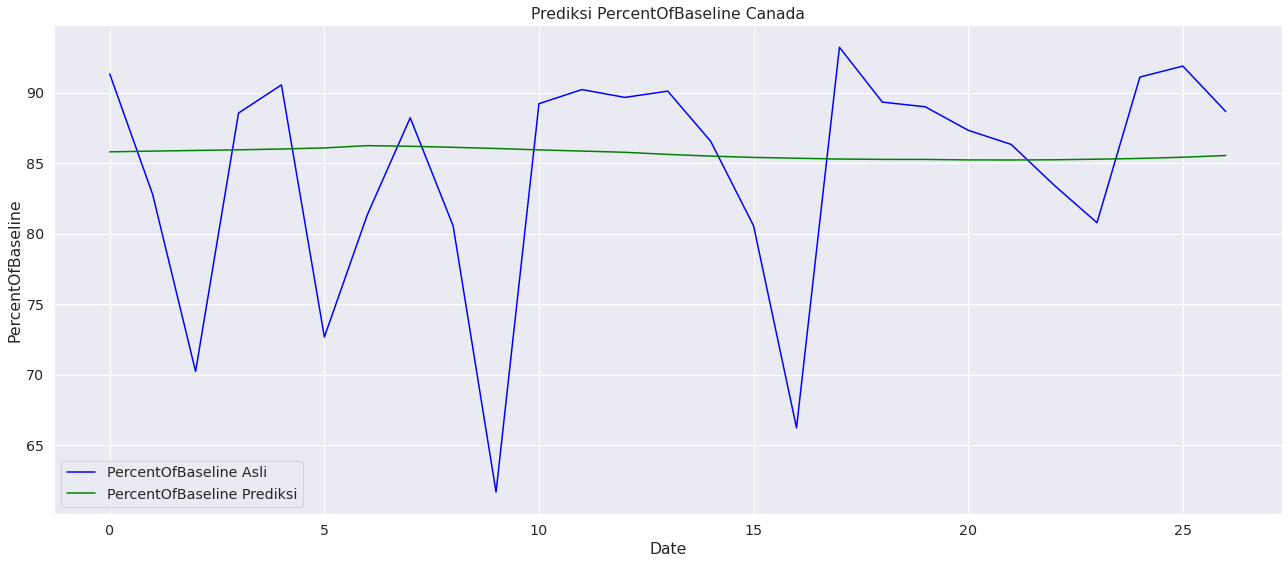

In [115]:
# Visualisasi hasil

plt.figure(figsize=(22,9))
plt.plot(real_percentofbaseline_canada, color = 'blue', label = 'PercentOfBaseline Asli')
plt.plot(predicted_percentofbaseline_canada, color = 'green', label = 'PercentOfBaseline Prediksi')
plt.title('Prediksi PercentOfBaseline Canada')
plt.xlabel('Date')
plt.ylabel('PercentOfBaseline')
plt.legend(loc="lower left")
plt.show()

#### 4.3 Negara Chile

In [168]:
# dataset Chile

df_chile.head()

,Date,PercentOfBaseline
302,2020-03-16,96
257,2020-03-17,72
393,2020-03-18,56
473,2020-03-19,52
414,2020-03-20,53


In [169]:
# membuat data train 

df_train_chile = df_chile[:214]

In [170]:
# melihat info

df_train_chile.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 214 entries, 302 to 391
Data columns (total 2 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Date               214 non-null    datetime64[ns]
 1   PercentOfBaseline  214 non-null    int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 5.0 KB


In [171]:
# memilih kolom yang digunakan

training_set_chile = df_train_chile['PercentOfBaseline']

In [172]:
# membuat dataframe train

training_set_chile = pd.DataFrame(training_set_chile)

In [173]:
# standarisasi nilai

scale_chile = MinMaxScaler(feature_range = (0, 1))

training_set_scaled_chile = scale_chile.fit_transform(training_set_chile)

In [174]:
# membuat struktur data dengan 30 timesteps dan 1 output

X_train = []
y_train = []

for i in range(30, 214):
    X_train.append(training_set_scaled_chile[i-30:i, 0])
    y_train.append(training_set_scaled_chile[i, 0])
    
X_train, y_train = np.array(X_train), np.array(y_train)

In [175]:
# Reshaping

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

In [176]:
# Inisialisasi RNN

model_chile = Sequential()

In [177]:
# menambahkan layer LSTM pertama dan mengatur Dropout
model_chile.add(LSTM(
    units = 60,
    activation = 'tanh',
    return_sequences = True,
    input_shape = (X_train.shape[1], 1)
))
model_chile.add(Dropout(0.2))

# menambahkan layer LSTM kedua dan mengatur Dropout
model_chile.add(LSTM(
    units = 80,
    activation = 'relu',
    return_sequences = True
))
model_chile.add(Dropout(0.2))

# menambahkan layer LSTM ketiga dan mengatur Dropout
model_chile.add(LSTM(
    units = 100,
    activation = 'tanh',
    return_sequences = True
))
model_chile.add(Dropout(0.2))

# menambahkan layer LSTM keempat dan mengatur Dropout
model_chile.add(LSTM(
    units = 120
))
model_chile.add(Dropout(0.2))

# menambahkan layer output
model_chile.add(Dense(
    units = 1
))

# rangkuman
model_chile.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_16 (LSTM)              (None, 30, 60)            14880     
                                                                 
 dropout_16 (Dropout)        (None, 30, 60)            0         
                                                                 
 lstm_17 (LSTM)              (None, 30, 80)            45120     
                                                                 
 dropout_17 (Dropout)        (None, 30, 80)            0         
                                                                 
 lstm_18 (LSTM)              (None, 30, 100)           72400     
                                                                 
 dropout_18 (Dropout)        (None, 30, 100)           0         
                                                                 
 lstm_19 (LSTM)              (None, 120)              

In [178]:
# Compile RNN

model_chile.compile(optimizer = 'adam', loss = 'mean_squared_error')

In [179]:
# menerapkan RNN ke dalam train set

epoch = 100 
batch_size = 32

model_chile.fit(X_train, y_train, epochs = epoch, batch_size = batch_size)

Epoch 1/100
6/6 [==============================] - 6s 71ms/step - loss: 0.0626
Epoch 2/100
6/6 [==============================] - 0s 73ms/step - loss: 0.0182
Epoch 3/100
6/6 [==============================] - 0s 67ms/step - loss: 0.0232
Epoch 4/100
6/6 [==============================] - 0s 67ms/step - loss: 0.0162
Epoch 5/100
6/6 [==============================] - 0s 71ms/step - loss: 0.0135
Epoch 6/100
6/6 [==============================] - 0s 65ms/step - loss: 0.0128
Epoch 7/100
6/6 [==============================] - 0s 65ms/step - loss: 0.0124
Epoch 8/100
6/6 [==============================] - 0s 65ms/step - loss: 0.0127
Epoch 9/100
6/6 [==============================] - 0s 69ms/step - loss: 0.0118
Epoch 10/100
6/6 [==============================] - 0s 76ms/step - loss: 0.0109
Epoch 11/100
6/6 [==============================] - 0s 69ms/step - loss: 0.0098
Epoch 12/100
6/6 [==============================] - 0s 71ms/step - loss: 0.0108
Epoch 13/100
6/6 [==============================]

In [180]:
# membuat data test

df_test_chile = df_chile[214:]

In [181]:
# melihat info

df_test_chile.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 24 entries, 351 to 338
Data columns (total 2 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Date               24 non-null     datetime64[ns]
 1   PercentOfBaseline  24 non-null     int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 576.0 bytes


In [182]:
# memilih kolom yang digunakan

testing_set_chile = df_test_chile['PercentOfBaseline']

In [183]:
# membuat dataframe test

testing_set_chile = pd.DataFrame(testing_set_chile)

In [184]:
# melihat info

testing_set_chile.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 24 entries, 351 to 338
Data columns (total 1 columns):
 #   Column             Non-Null Count  Dtype
---  ------             --------------  -----
 0   PercentOfBaseline  24 non-null     int64
dtypes: int64(1)
memory usage: 384.0 bytes


In [185]:
# melihat data asli

real_percentofbaseline_chile = testing_set_chile.values

real_percentofbaseline_chile

array([[57],
       [48],
       [52],
       [52],
       [59],
       [60],
       [63],
       [41],
       [65],
       [62],
       [62],
       [60],
       [64],
       [31],
       [26],
       [58],
       [44],
       [47],
       [50],
       [48],
       [39],
       [65],
       [45],
       [48]])

In [186]:
# mendapatkan data prediksi

dataset_total_chile = pd.concat((df_train_chile['PercentOfBaseline'], df_test_chile['PercentOfBaseline']), axis = 0)

inputs_chile = dataset_total_chile[len(dataset_total_chile) - len(df_test_chile) - 30:].values
inputs_chile = inputs_chile.reshape(-1, 1)
inputs_chile = scale_chile.transform(inputs_chile)

X_test = []

for i in range(30, 54):
    X_test.append(inputs_chile[i-30:i, 0])

X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

predicted_percentofbaseline_chile = model_chile.predict(X_test)
predicted_percentofbaseline_chile = scale_chile.inverse_transform(predicted_percentofbaseline_chile)

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"


In [187]:
# melihat X_test

X_test.shape

(24, 30, 1)

In [188]:
# membuat dataframe prediksi

predicted_percentofbaseline_chile = pd.DataFrame(predicted_percentofbaseline_chile)

In [189]:
# melihat info

predicted_percentofbaseline_chile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24 entries, 0 to 23
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       24 non-null     float32
dtypes: float32(1)
memory usage: 224.0 bytes


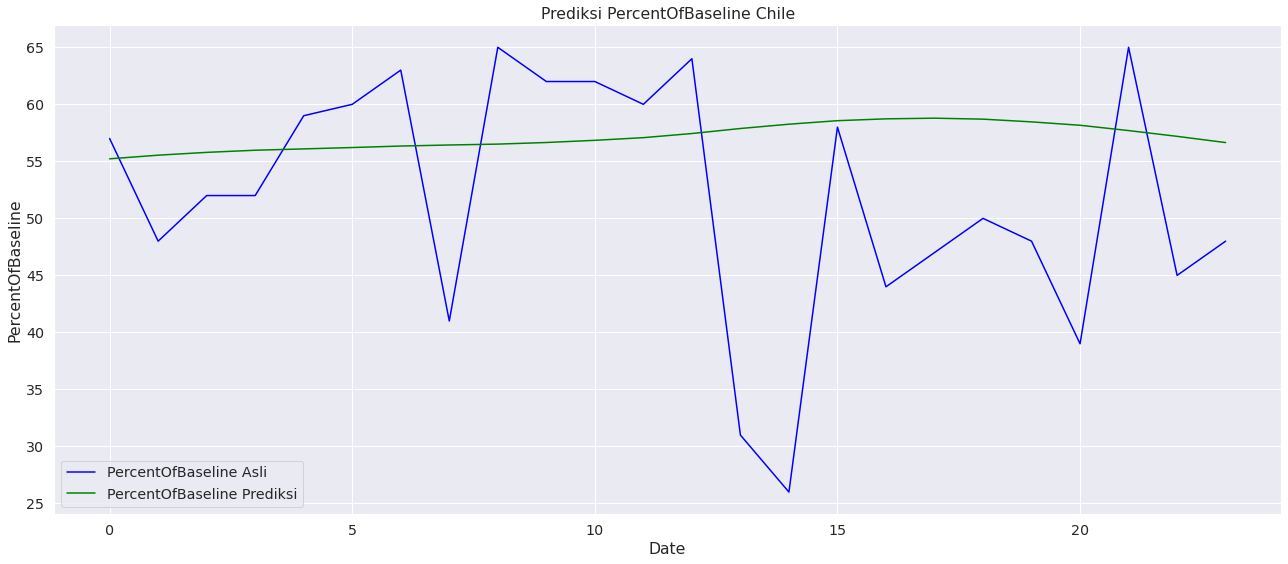

In [190]:
# Visualisasi hasil

plt.figure(figsize=(22,9))
plt.plot(real_percentofbaseline_chile, color = 'blue', label = 'PercentOfBaseline Asli')
plt.plot(predicted_percentofbaseline_chile, color = 'green', label = 'PercentOfBaseline Prediksi')
plt.title('Prediksi PercentOfBaseline Chile')
plt.xlabel('Date')
plt.ylabel('PercentOfBaseline')
plt.legend(loc="lower left")
plt.show()

#### 4.4 Negara Australia

In [191]:
# dataset Australia

df_australia.head()

,Date,PercentOfBaseline
171,2020-03-16,92
31,2020-03-17,90
129,2020-03-18,97
84,2020-03-19,89
65,2020-03-20,85


In [193]:
# membuat data train 

df_train_australia = df_australia[:231]

In [194]:
# melihat info

df_train_australia.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 231 entries, 171 to 14
Data columns (total 2 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Date               231 non-null    datetime64[ns]
 1   PercentOfBaseline  231 non-null    int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 5.4 KB


In [195]:
# memilih kolom yang digunakan

training_set_australia = df_train_australia['PercentOfBaseline']

In [196]:
# membuat dataframe train

training_set_australia = pd.DataFrame(training_set_australia)

In [197]:
# standarisasi nilai

scale_australia = MinMaxScaler(feature_range = (0, 1))

training_set_scaled_australia = scale_australia.fit_transform(training_set_australia)

In [199]:
# membuat struktur data dengan 30 timesteps dan 1 output

X_train = []
y_train = []

for i in range(30, 231):
    X_train.append(training_set_scaled_australia[i-30:i, 0])
    y_train.append(training_set_scaled_australia[i, 0])
    
X_train, y_train = np.array(X_train), np.array(y_train)

In [200]:
# Reshaping

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

In [201]:
# Inisialisasi RNN

model_australia = Sequential()

In [202]:
# menambahkan layer LSTM pertama dan mengatur Dropout
model_australia.add(LSTM(
    units = 60,
    activation = 'tanh',
    return_sequences = True,
    input_shape = (X_train.shape[1], 1)
))
model_australia.add(Dropout(0.2))

# menambahkan layer LSTM kedua dan mengatur Dropout
model_australia.add(LSTM(
    units = 80,
    activation = 'relu',
    return_sequences = True
))
model_australia.add(Dropout(0.2))

# menambahkan layer LSTM ketiga dan mengatur Dropout
model_australia.add(LSTM(
    units = 100,
    activation = 'tanh',
    return_sequences = True
))
model_australia.add(Dropout(0.2))

# menambahkan layer LSTM keempat dan mengatur Dropout
model_australia.add(LSTM(
    units = 120
))
model_australia.add(Dropout(0.2))

# menambahkan layer output
model_australia.add(Dense(
    units = 1
))

# rangkuman
model_australia.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_20 (LSTM)              (None, 30, 60)            14880     
                                                                 
 dropout_20 (Dropout)        (None, 30, 60)            0         
                                                                 
 lstm_21 (LSTM)              (None, 30, 80)            45120     
                                                                 
 dropout_21 (Dropout)        (None, 30, 80)            0         
                                                                 
 lstm_22 (LSTM)              (None, 30, 100)           72400     
                                                                 
 dropout_22 (Dropout)        (None, 30, 100)           0         
                                                                 
 lstm_23 (LSTM)              (None, 120)              

In [203]:
# Compile RNN

model_australia.compile(optimizer = 'adam', loss = 'mean_squared_error')

In [204]:
# menerapkan RNN ke dalam train set

epoch = 100 
batch_size = 32

model_australia.fit(X_train, y_train, epochs = epoch, batch_size = batch_size)

Epoch 1/100
7/7 [==============================] - 7s 71ms/step - loss: 0.0700
Epoch 2/100
7/7 [==============================] - 1s 77ms/step - loss: 0.0332
Epoch 3/100
7/7 [==============================] - 0s 69ms/step - loss: 0.0227
Epoch 4/100
7/7 [==============================] - 0s 68ms/step - loss: 0.0175
Epoch 5/100
7/7 [==============================] - 0s 67ms/step - loss: 0.0155
Epoch 6/100
7/7 [==============================] - 0s 70ms/step - loss: 0.0167
Epoch 7/100
7/7 [==============================] - 0s 65ms/step - loss: 0.0188
Epoch 8/100
7/7 [==============================] - 0s 69ms/step - loss: 0.0200
Epoch 9/100
7/7 [==============================] - 0s 64ms/step - loss: 0.0186
Epoch 10/100
7/7 [==============================] - 0s 71ms/step - loss: 0.0148
Epoch 11/100
7/7 [==============================] - 0s 68ms/step - loss: 0.0151
Epoch 12/100
7/7 [==============================] - 0s 66ms/step - loss: 0.0136
Epoch 13/100
7/7 [==============================]

In [205]:
# membuat data test

df_test_australia = df_australia[231:]

In [206]:
# melihat info

df_test_australia.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26 entries, 158 to 198
Data columns (total 2 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Date               26 non-null     datetime64[ns]
 1   PercentOfBaseline  26 non-null     int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 624.0 bytes


In [207]:
# memilih kolom yang digunakan

testing_set_australia = df_test_australia['PercentOfBaseline']

In [208]:
# membuat dataframe test

testing_set_australia = pd.DataFrame(testing_set_australia)

In [209]:
# melihat info

testing_set_australia.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26 entries, 158 to 198
Data columns (total 1 columns):
 #   Column             Non-Null Count  Dtype
---  ------             --------------  -----
 0   PercentOfBaseline  26 non-null     int64
dtypes: int64(1)
memory usage: 416.0 bytes


In [210]:
# melihat data asli

real_percentofbaseline_australia = testing_set_australia.values

real_percentofbaseline_australia

array([[20],
       [24],
       [21],
       [27],
       [28],
       [20],
       [23],
       [18],
       [26],
       [23],
       [22],
       [25],
       [22],
       [27],
       [33],
       [18],
       [22],
       [25],
       [28],
       [25],
       [18],
       [46],
       [28],
       [29],
       [21],
       [27]])

In [211]:
# mendapatkan data prediksi

dataset_total_australia = pd.concat((df_train_australia['PercentOfBaseline'], df_test_australia['PercentOfBaseline']), axis = 0)

inputs_australia = dataset_total_australia[len(dataset_total_australia) - len(df_test_australia) - 30:].values
inputs_australia = inputs_australia.reshape(-1, 1)
inputs_australia = scale_australia.transform(inputs_australia)

X_test = []

for i in range(30, 56):
    X_test.append(inputs_australia[i-30:i, 0])

X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

predicted_percentofbaseline_australia = model_australia.predict(X_test)
predicted_percentofbaseline_australia = scale_australia.inverse_transform(predicted_percentofbaseline_australia)

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"


In [212]:
# melihat X_test

X_test.shape

(26, 30, 1)

In [213]:
# membuat dataframe prediksi

predicted_percentofbaseline_australia = pd.DataFrame(predicted_percentofbaseline_australia)

In [214]:
# melihat info

predicted_percentofbaseline_australia.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26 entries, 0 to 25
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       26 non-null     float32
dtypes: float32(1)
memory usage: 232.0 bytes


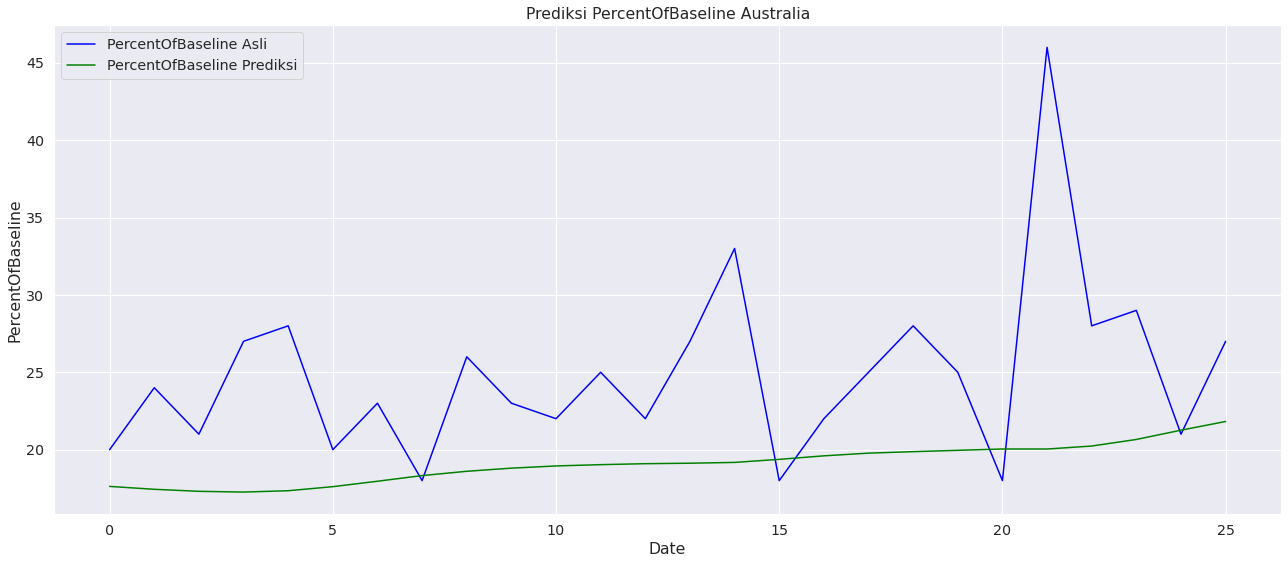

In [216]:
# Visualisasi hasil

plt.figure(figsize=(22,9))
plt.plot(real_percentofbaseline_australia, color = 'blue', label = 'PercentOfBaseline Asli')
plt.plot(predicted_percentofbaseline_australia, color = 'green', label = 'PercentOfBaseline Prediksi')
plt.title('Prediksi PercentOfBaseline Australia')
plt.xlabel('Date')
plt.ylabel('PercentOfBaseline')
plt.legend(loc="upper left")
plt.show()